# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [1]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [2]:
# All the imports for the notebook to work
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans

## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [3]:
# Fetching from CSV as it's easier for me
wine_red = pd.read_csv("./data/winequality-red.csv", sep=";")
wine_white = pd.read_csv("./data/winequality-white.csv", sep=";")
# Adding a color column
wine_red["color"] = "red"
wine_white["color"] = "white"

# Base data should not be modified
base_data = pd.concat([wine_red, wine_white], axis=0, ignore_index=True)

# This is to avoid aving red - white ordered already...
base_data = base_data.sample(frac=1, random_state=42).reset_index(drop=True)
base_data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.17,0.74,12.80,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,8,white
1,7.7,0.64,0.21,2.20,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,5,red
2,6.8,0.39,0.34,7.40,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,7,white
3,6.3,0.28,0.47,11.20,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,6,white
4,7.4,0.35,0.20,13.90,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,6,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.6,0.32,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.2,5,white
6493,5.6,0.28,0.27,3.90,0.043,52.0,158.0,0.99202,3.35,0.44,10.7,7,white
6494,6.4,0.37,0.20,5.60,0.117,61.0,183.0,0.99459,3.24,0.43,9.5,5,white
6495,6.5,0.26,0.50,8.00,0.051,46.0,197.0,0.99536,3.18,0.47,9.5,5,white


In [4]:
target = "color"
features = [x for x in base_data.columns.values if x != target]
x_base: pd.DataFrame = base_data[features]
y_base: pd.DataFrame = base_data[target]

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [5]:
# Complete this cell with your code
x_base.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


We can see that there is no 'hole' in the data. No NaN or null values

In [6]:
y_base.describe()

count      6497
unique        2
top       white
freq       4898
Name: color, dtype: object

As we can see, the data is unbalanced, as there is way more white than red wine.

## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [7]:
red_wine = base_data[base_data["color"] == "red"]
white_wine = base_data[base_data["color"] == "white"]

In [8]:
red_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [9]:
white_wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [10]:
def getSSMD(frame1: pd.DataFrame, frame2: pd.DataFrame):
    ssmd_values = {}
    d1 = frame1.describe()
    d2 = frame2.describe()
    for c in d1.columns.values:
        u1 = d1[c]["mean"]
        u2 = d2[c]["mean"]
        o1 = d1[c]["std"]
        o2 = d2[c]["std"]
        ssmd_values[c] = (u1 - u2) / (math.sqrt(math.pow(o1, 2) + math.pow(o2, 2)))
    return ssmd_values

In [11]:
ssmd = getSSMD(red_wine, white_wine)
ssmd

{'fixed acidity': 0.7570984913882014,
 'volatile acidity': 1.2146180859422453,
 'citric acid': -0.2756520281549347,
 'residual sugar': -0.7318262377213726,
 'chlorides': 0.8035252800557684,
 'free sulfur dioxide': -0.9732927083649252,
 'total sulfur dioxide': -1.7098935451586068,
 'density': 0.7689026646491103,
 'pH': 0.5688537900809766,
 'sulphates': 0.8236123900161842,
 'alcohol': -0.05607448758109532,
 'quality': -0.20181608588284952}

Here, we can already have an idea of which features will be significants to split the data. As the more differences there is the more the data is splittable easily per feature.

Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

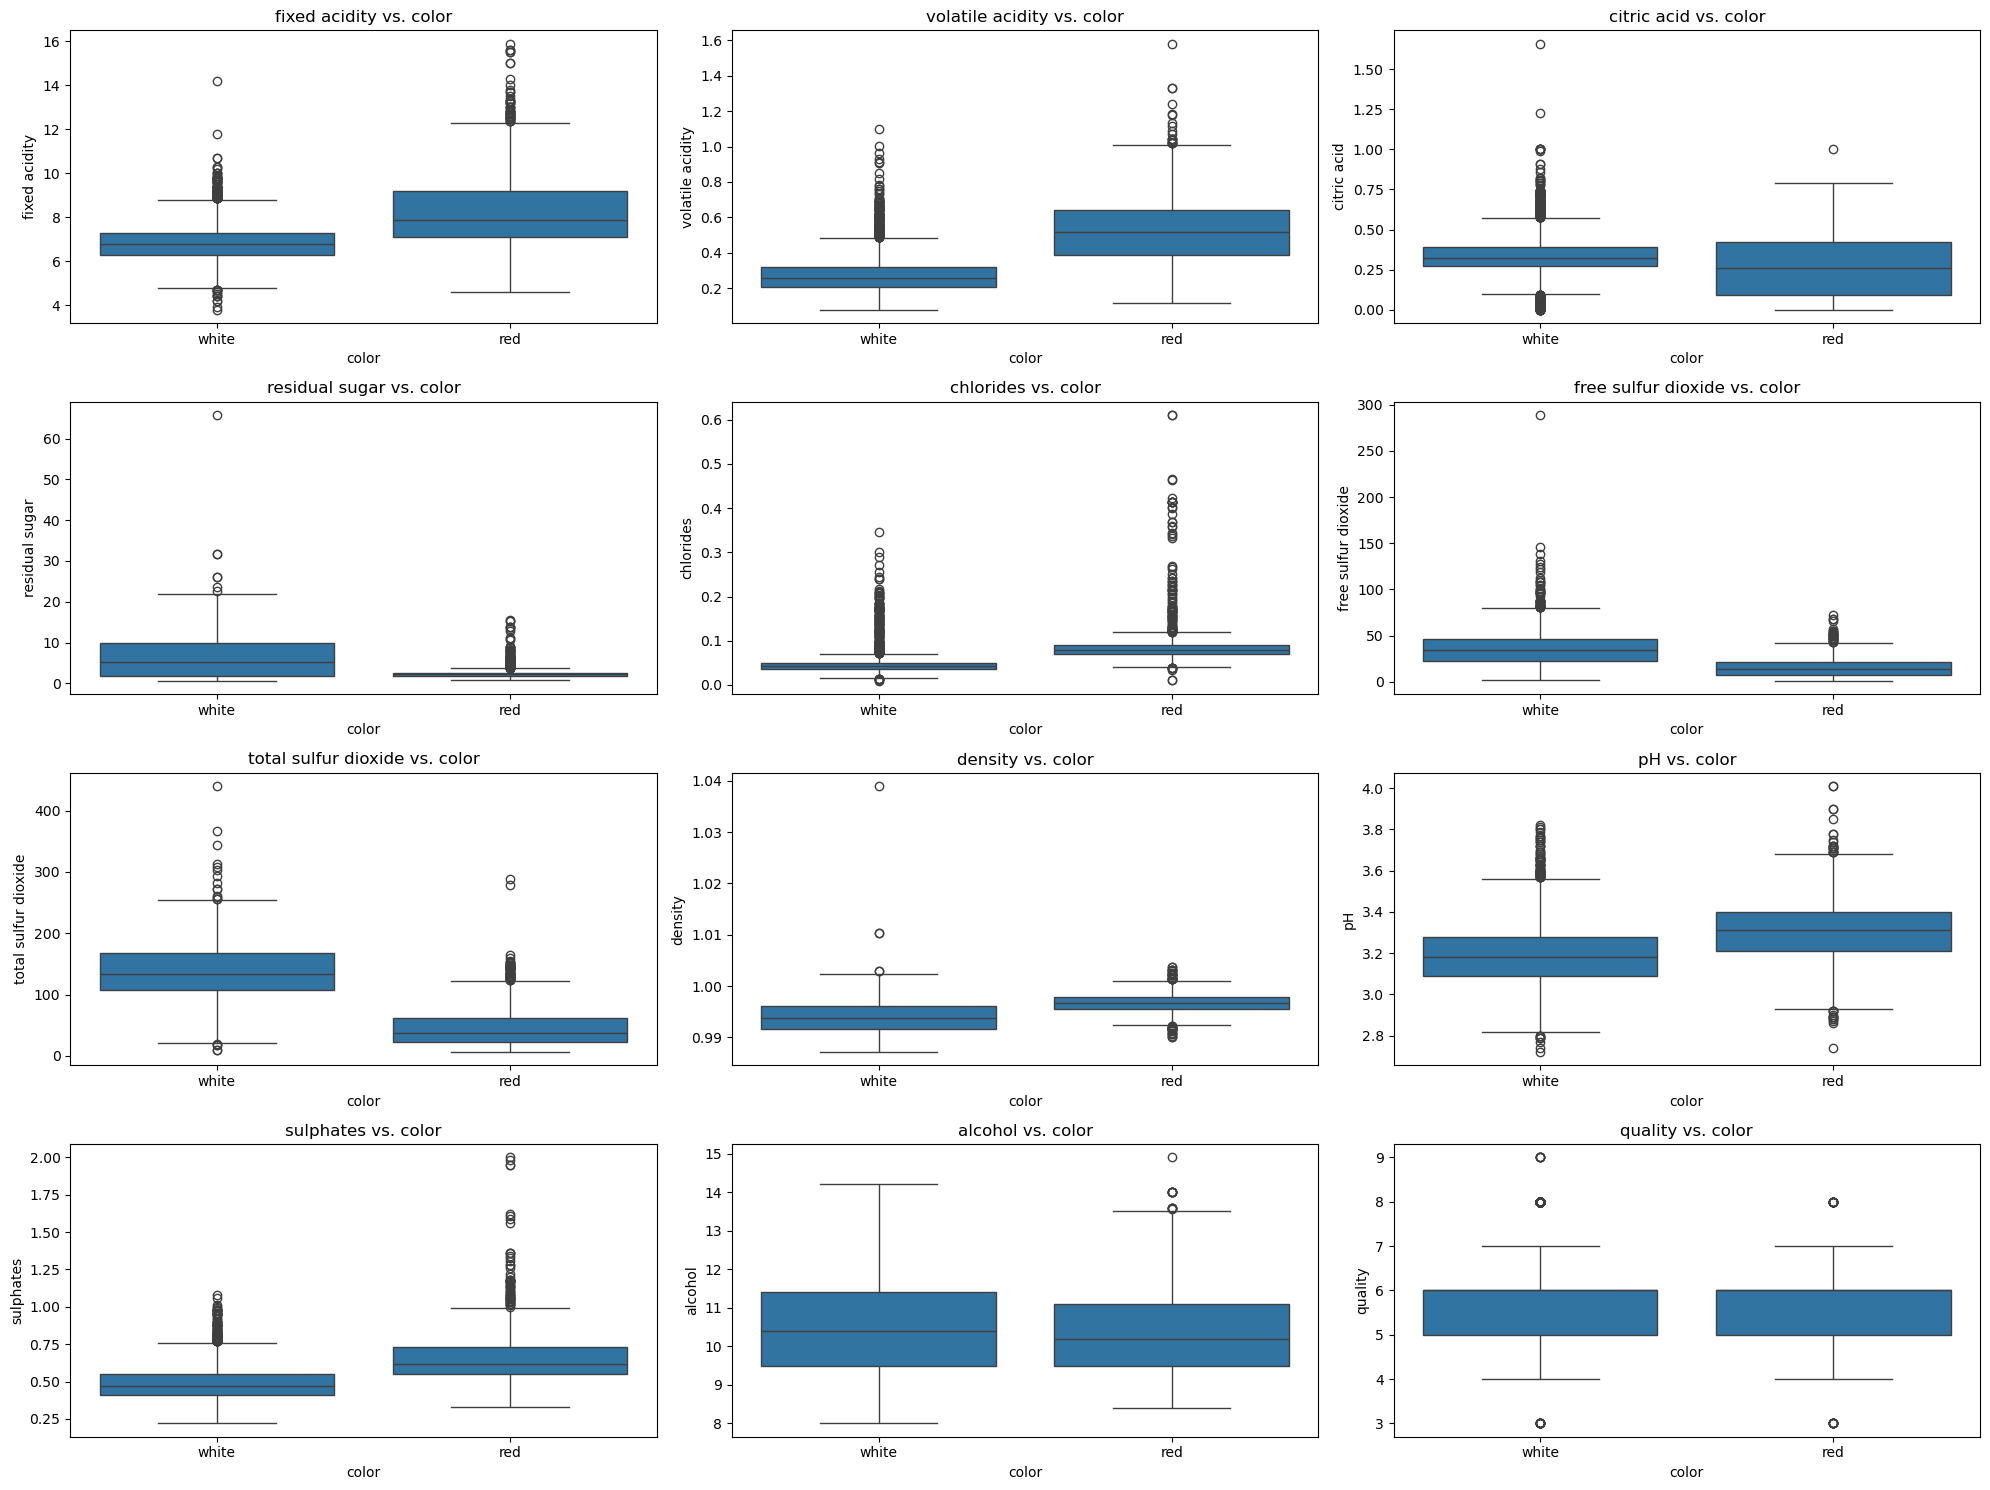

In [12]:
# Complete this cell with your code
# Set up the plot
plt.figure(figsize=(20, 15))

# Create violin plots for each feature
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x="color", y=feature, data=base_data)
    plt.title(f"{feature} vs. color")
    plt.xlabel("color")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

On those graphs, we can see some features that might be used to split the data. We can see some that are unsplittable, as the quality..

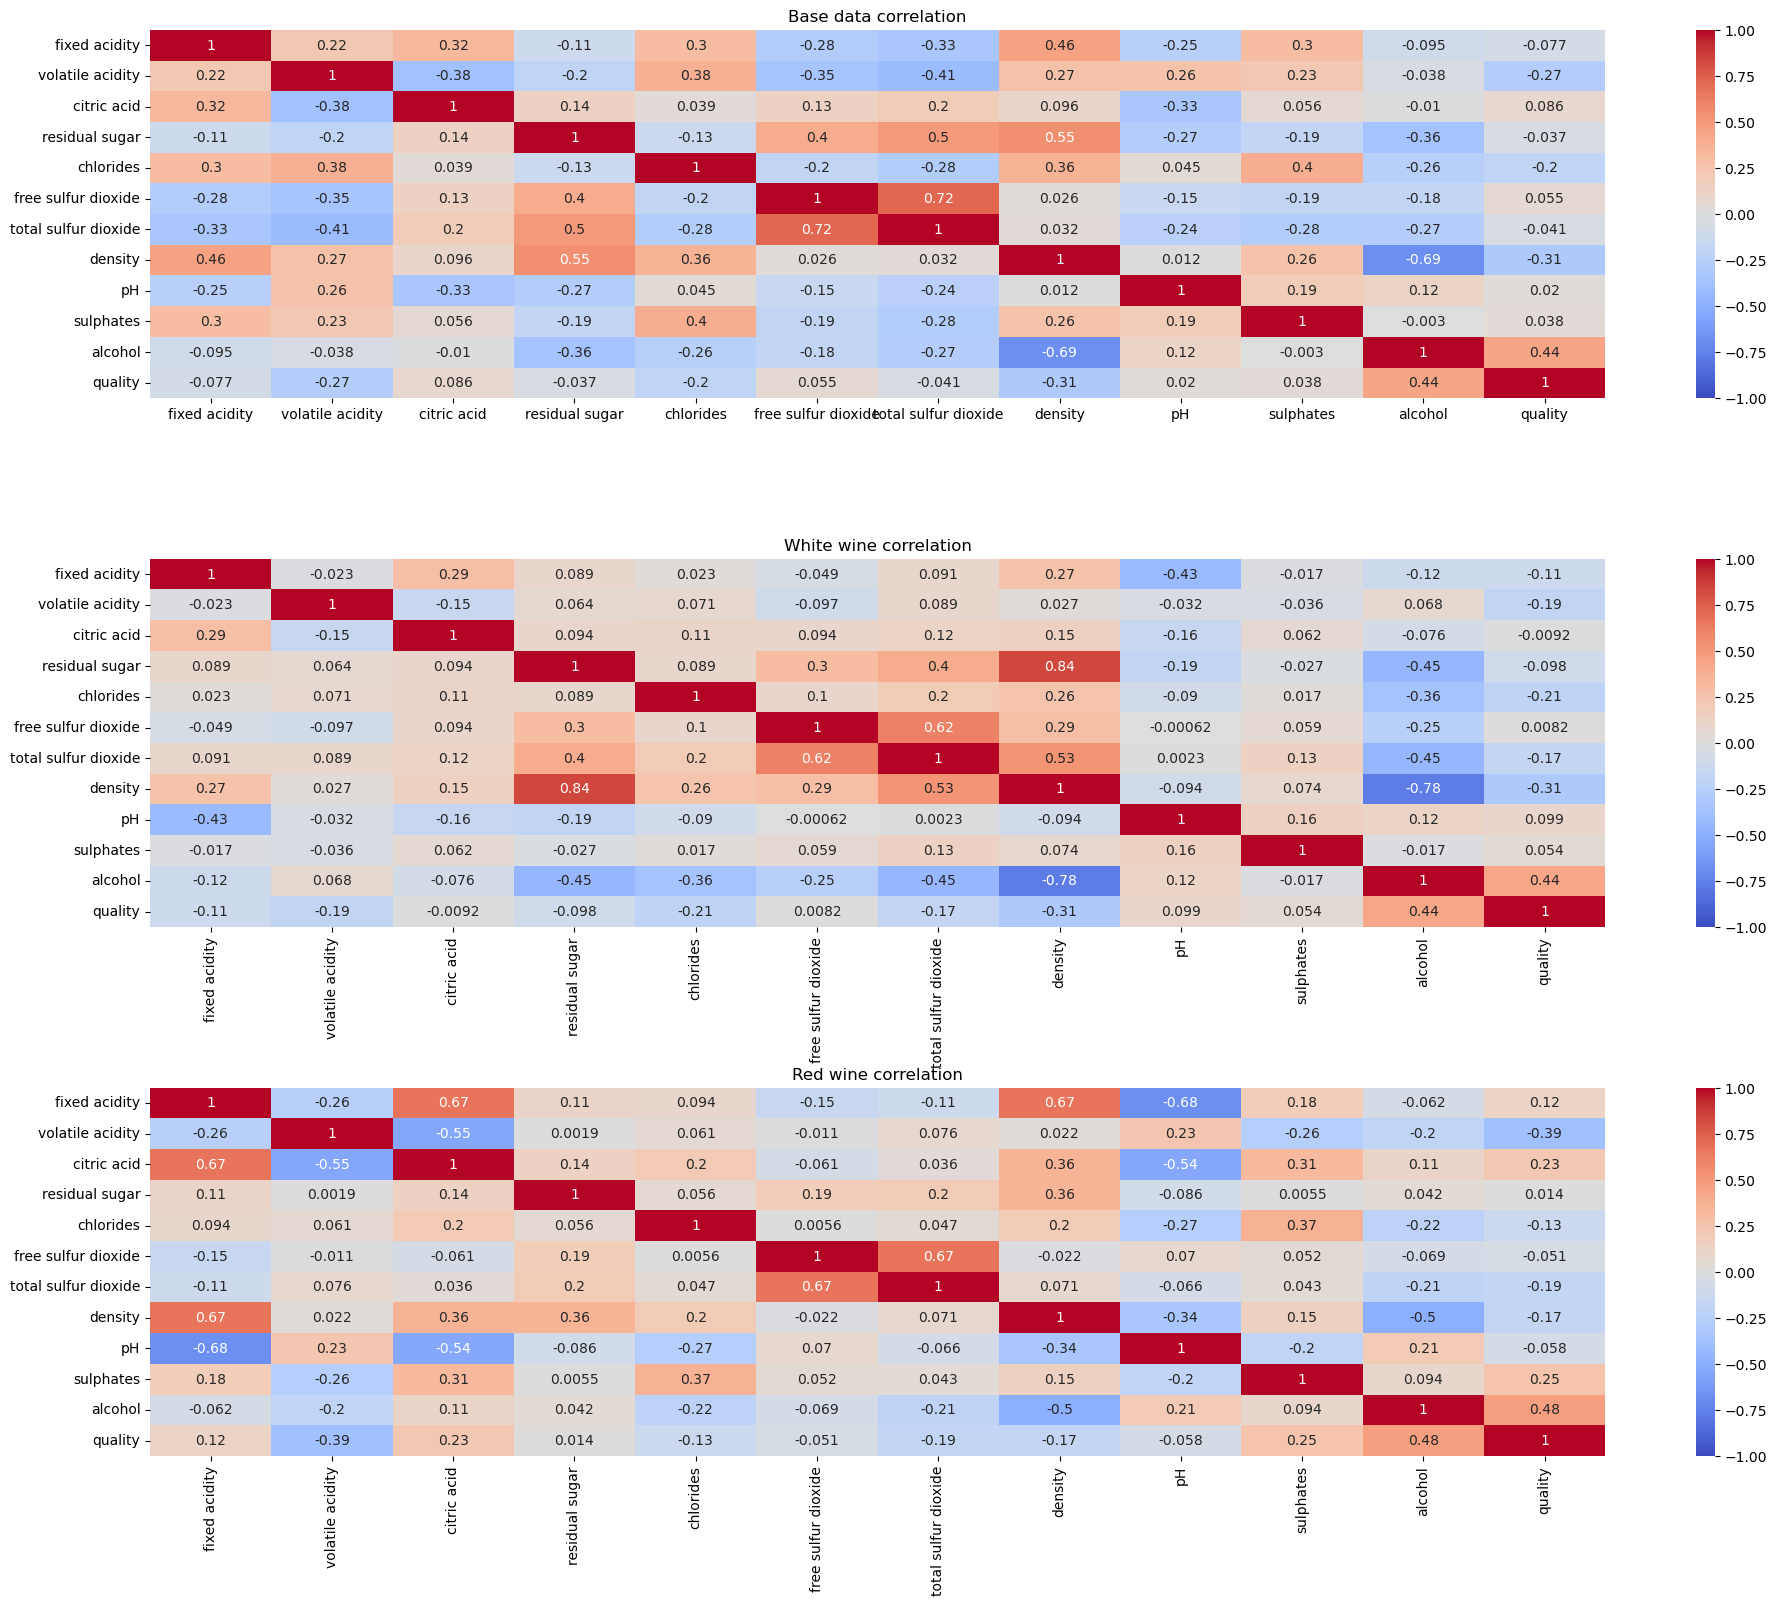

In [13]:
plt.figure(figsize=(20, 15))


# For base data
plt.subplot(3, 1, 1)
plt.tight_layout()
sns.heatmap(
    base_data[features].corr(),
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
)
plt.title("Base data correlation")

# For white wine
plt.subplot(3, 1, 2)
plt.tight_layout()
sns.heatmap(
    white_wine[features].corr(),
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
)
plt.title("White wine correlation")

# For red wine
plt.subplot(3, 1, 3)
plt.tight_layout()
sns.heatmap(
    red_wine[features].corr(),
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
)
plt.title("Red wine correlation")

# Show the plot
plt.show()

Here, we can observe that some correlations are present in both red and white wines, but not at the same level. and some are completly absent/inverted

## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

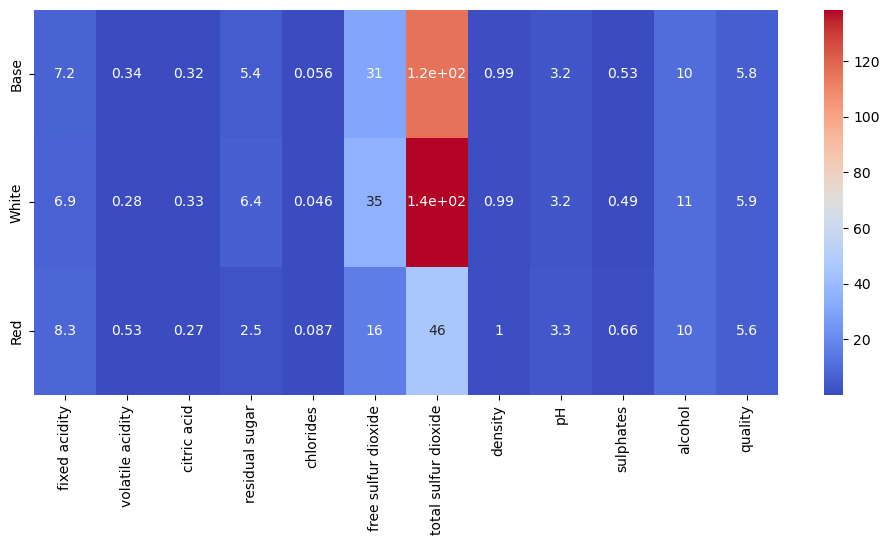

In [14]:
# Complete this cell with your code
base_features_means = base_data[features].mean()
white_features_means = white_wine[features].mean()
red_features_means = red_wine[features].mean()
ylbl = ["Base", "White", "Red"]
plt.figure(figsize=(12, 5))
sns.heatmap(
    [base_features_means, white_features_means, red_features_means],
    annot=True,
    cmap="coolwarm",
    xticklabels=features,
    yticklabels=ylbl,
)
plt.show()

The easiest way seems to be on the total sulfur dioxide. As the values differenciate greatly between the two

### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

In [15]:
# Complete this cell with your code


scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_base)

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)
pca_df = pd.DataFrame(data=x_pca, columns=["PC1", "PC2"])

pca_df["color"] = y_base.reset_index(drop=True)

In [16]:
components = list(zip(pca.components_[0], pca.components_[1]))
components

[(-0.2569287331108535, 0.26184306204602015),
 (-0.39493117944046174, 0.10519825134119526),
 (0.14646061066301436, 0.1440934849469867),
 (0.3189051914749266, 0.34258496764107266),
 (-0.3134499396675332, 0.26977009551276876),
 (0.4226913715672136, 0.1111787805638863),
 (0.4744196843566576, 0.1439475285736659),
 (-0.09243753243272002, 0.5549204739711832),
 (-0.20806956645989705, -0.15292185359766805),
 (-0.2998519160898691, 0.11963420329954372),
 (-0.05892408274769738, -0.4927274740495645),
 (0.08747570978774036, -0.2966009063197228)]

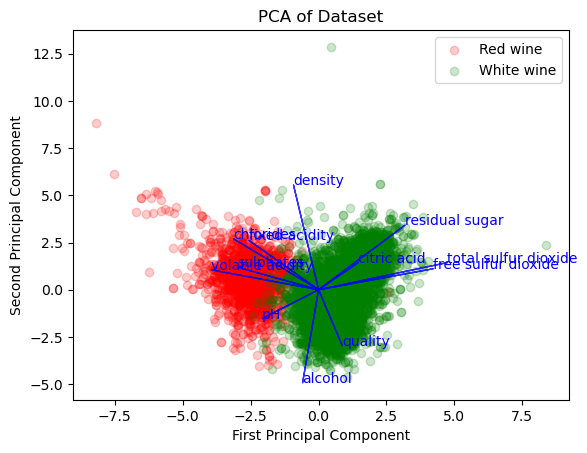

In [17]:
plt.figure()
plt.scatter(
    pca_df[pca_df["color"] == "red"]["PC1"],
    pca_df[pca_df["color"] == "red"]["PC2"],
    c="red",
    alpha=0.2,
)
plt.scatter(
    pca_df[pca_df["color"] == "white"]["PC1"],
    pca_df[pca_df["color"] == "white"]["PC2"],
    c="green",
    alpha=0.2,
)
ARROW_SCALE = 10
for i, (x, y) in enumerate(components):
    currX = x * ARROW_SCALE
    currY = y * ARROW_SCALE
    plt.arrow(0, 0, currX, currY, color="b", alpha=0.8)
    plt.text(currX, currY, base_data.columns.values[i], color="b")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend(["Red wine", "White wine"])
plt.title("PCA of Dataset")
plt.show()

As we can see, the PCA keeps our groups well separated. This means that there is a real separation available in the data. 

### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

In [18]:
kmeans_pca = KMeans(n_clusters=2, random_state=0)
kmeans_pca.fit(pca_df[["PC1", "PC2"]])
kmeans_pca.labels_

array([1, 0, 1, ..., 1, 1, 0], dtype=int32)

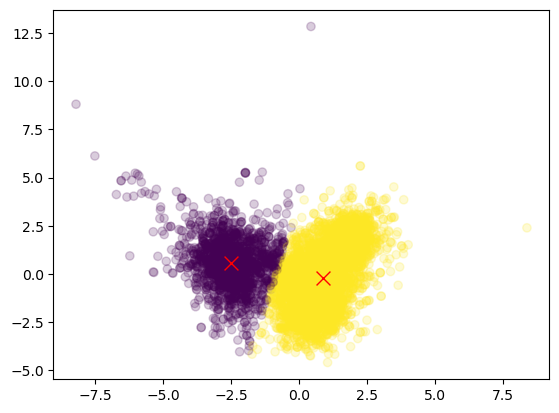

In [19]:
plt.scatter(
    pca_df["PC1"], pca_df["PC2"], c=kmeans_pca.labels_, cmap="viridis", alpha=0.2
)
plt.scatter(
    kmeans_pca.cluster_centers_[:, 0],
    kmeans_pca.cluster_centers_[:, 1],
    marker="x",
    s=100,
    linewidths=1,
    color="r",
)
plt.show()

In [20]:
lblEncoder = LabelEncoder()
lblEncoder.fit(["red", "white"])

# Or we can encore the [0,1,0...] to ["white", "red", "white"..] to match the pca_df
y_pred_pca = lblEncoder.inverse_transform(kmeans_pca.labels_)
print(classification_report(pca_df["color"], y_pred_pca))

              precision    recall  f1-score   support

         red       0.92      0.98      0.95      1599
       white       0.99      0.97      0.98      4898

    accuracy                           0.98      6497
   macro avg       0.96      0.98      0.97      6497
weighted avg       0.98      0.98      0.98      6497



In [21]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(x_base)

y_pred_pca = []
for x in kmeans.labels_:
    if x == 0:
        y_pred_pca.append("red")
    else:
        y_pred_pca.append("white")
print(classification_report(y_base, y_pred_pca))

              precision    recall  f1-score   support

         red       0.54      0.95      0.69      1599
       white       0.98      0.74      0.84      4898

    accuracy                           0.79      6497
   macro avg       0.76      0.84      0.77      6497
weighted avg       0.87      0.79      0.80      6497



We can see that the KMeans works better after the PCA, as the non important features have been removed. We can see too that the precision on the red wine is less good. This is probably due to the imbalance of our data

Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

In [22]:
x_train, x_test, y_train, y_test = train_test_split(
    x_base, y_base, train_size=0.8, random_state=42
)

In [23]:
logreg = LogisticRegression()

paramsGrid = {
    "C": [0.01, 0.1, 1, 10, 50, 75, 100, 200],
}

scaler = StandardScaler()
lblEncoder2 = LabelEncoder()
y_train_encoded = lblEncoder2.fit_transform(y_train)
x_train_scaled = scaler.fit_transform(x_train)

cv = GridSearchCV(logreg, paramsGrid, scoring="f1")
cv.fit(x_train_scaled, y_train_encoded)
print(f"Best params were {cv.best_params_}")
print(f"Best score is {cv.best_score_}")
bestModel = cv.best_estimator_

Best params were {'C': 50}
Best score is 0.9960368560655614


In [24]:
y_predict = bestModel.predict(scaler.transform(x_test))

print(
    classification_report(
        y_true=y_test, y_pred=lblEncoder2.inverse_transform(y_predict)
    )
)

              precision    recall  f1-score   support

         red       0.99      0.98      0.99       309
       white       0.99      1.00      1.00       991

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [25]:
# Complete this cell with your code
for i, x in enumerate(bestModel.coef_[0]):
    print(f"{features[i]} : {x}")

fixed acidity : 0.007534354995156941
volatile acidity : -1.269163700765758
citric acid : 0.4314376717282913
residual sugar : 4.9440689288552315
chlorides : -0.8477166330231628
free sulfur dioxide : -0.8990804769560243
total sulfur dioxide : 2.7851187309232572
density : -5.02816765131531
pH : 0.130666048396102
sulphates : -0.5069419267433969
alcohol : -1.7964356607824754
quality : -0.45772261836563544


It is compatible with what we saw on the plots on the analysis. The one that suprise me, is the density. It is higher than I expected.

It may be due to the data imbalance in the first place...

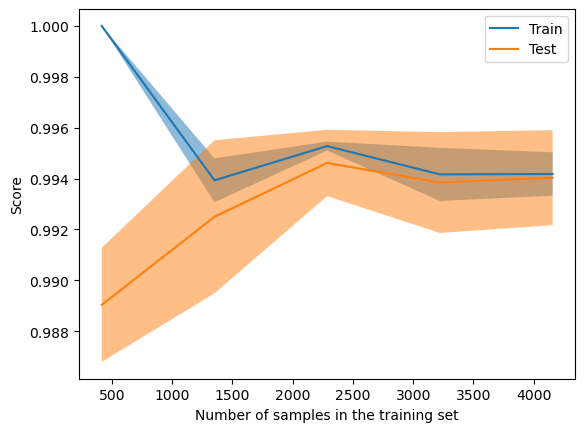

In [26]:
from sklearn.model_selection import LearningCurveDisplay


LearningCurveDisplay.from_estimator(
    bestModel, x_train_scaled, y_train_encoded, n_jobs=-1
)

This graph shows us that we may encounter overfitting, but it's not very clear. As the incertitude is quite big compared to the percentage changes

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [27]:
# Complete this cell with your code
def modelWithoutDens():
    features_without_dens = [x for x in features if x != "density"]
    logreg = LogisticRegression()
    paramsGrid = {
        "C": [0.01, 0.1, 1, 10, 50, 75, 100, 200],
    }
    x_train, x_test, y_train, y_test = train_test_split(
        x_base[features_without_dens], y_base, train_size=0.6
    )
    scaler = StandardScaler()
    lblEncoder = LabelEncoder()
    y_train_encoded = lblEncoder.fit_transform(y_train)
    x_train_scaled = scaler.fit_transform(x_train)

    cv = GridSearchCV(logreg, paramsGrid, scoring="f1")
    cv.fit(x_train_scaled, y_train_encoded)
    print(f"Best params were {cv.best_params_}")
    print(f"Best score is {cv.best_score_}")
    bestModel = cv.best_estimator_
    y_predict = lblEncoder.inverse_transform(bestModel.predict(x_test))
    print(classification_report(y_pred=y_predict, y_true=y_test))


# Resultats bizarres...
modelWithoutDens()

Best params were {'C': 0.1}
Best score is 0.9915504920073678
              precision    recall  f1-score   support

         red       0.00      0.00      0.00       652
       white       0.75      1.00      0.86      1947

    accuracy                           0.75      2599
   macro avg       0.37      0.50      0.43      2599
weighted avg       0.56      0.75      0.64      2599



/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and bein

In [28]:
def trainL1():
    logreg = LogisticRegression(solver="saga")
    paramsGrid = {
        "C": [0.01, 0.1, 1, 10, 50, 75, 100, 200],
        "penalty": ["l1"],
    }
    x_train, x_test, y_train, y_test = train_test_split(x_base, y_base, train_size=0.8)
    scaler = StandardScaler()
    lblEncoder = LabelEncoder()
    y_train_encoded = lblEncoder.fit_transform(y_train)
    x_train_scaled = scaler.fit_transform(x_train)

    cv = GridSearchCV(logreg, paramsGrid, scoring="f1")
    cv.fit(x_train_scaled, y_train_encoded)
    print(f"Best params were {cv.best_params_}")
    print(f"Best score is {cv.best_score_}")
    bestModel = cv.best_estimator_
    y_predict = lblEncoder.inverse_transform(bestModel.predict(x_test))
    print(classification_report(y_pred=y_predict, y_true=y_test))


trainL1()

/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/marttave/micromamba/lib/python3.10/site-pack

Best params were {'C': 1, 'penalty': 'l1'}
Best score is 0.9962888532846126
              precision    recall  f1-score   support

         red       0.50      0.00      0.01       308
       white       0.76      1.00      0.87       992

    accuracy                           0.76      1300
   macro avg       0.63      0.50      0.44      1300
weighted avg       0.70      0.76      0.66      1300



### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

/home/marttave/micromamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


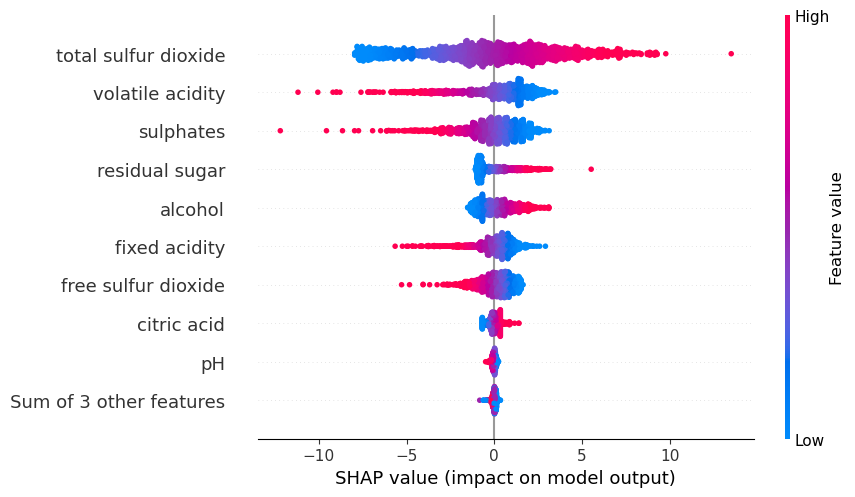

In [29]:
import shap


def getShapBeeswarmGraph():
    lg = LogisticRegression(C=50)
    x_train, x_test, y_train, y_test = train_test_split(x_base, y_base, train_size=0.8)
    lg.fit(x_train, y_train)

    explainer = shap.Explainer(lg, x_train, feature_names=feature)
    shap_values = explainer(x_test)

    shap.plots.beeswarm(shap_values)


getShapBeeswarmGraph()

We can see in this graph that there are some features that are pretty determinant on that makes a wine red or white.

For example, the total sulfur dioxide, aor the volatile acidity. Etc...

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


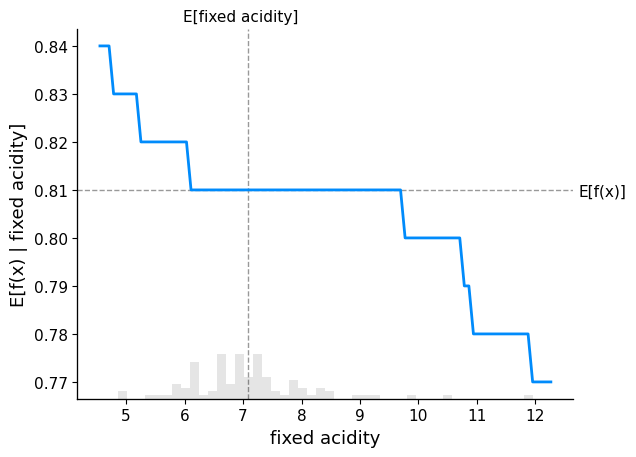

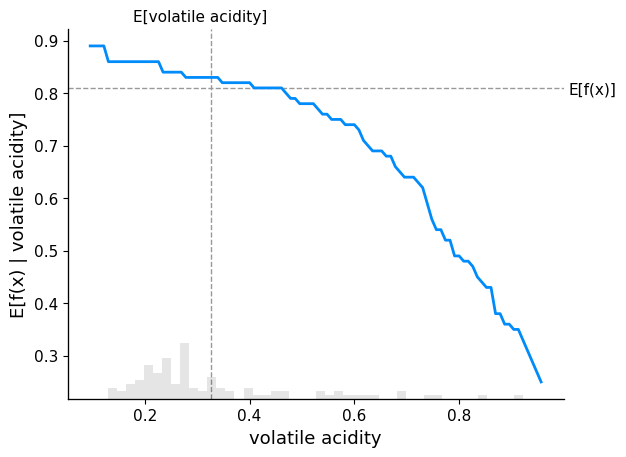

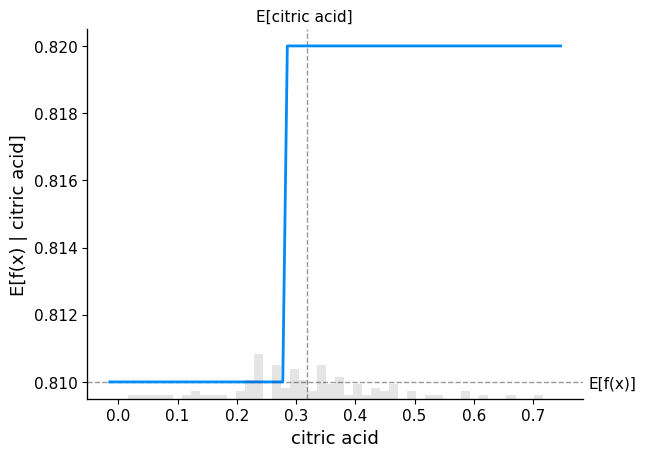

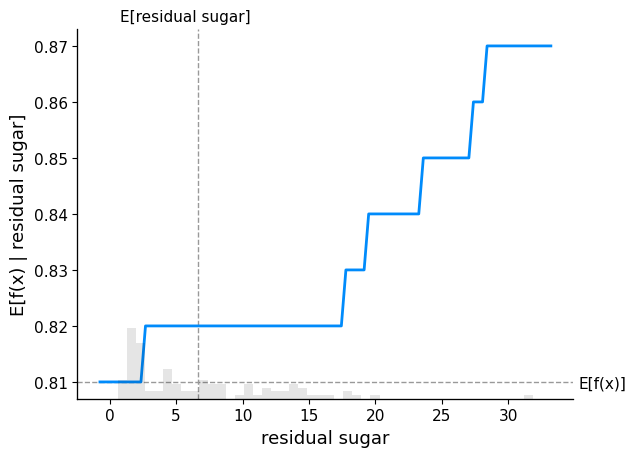

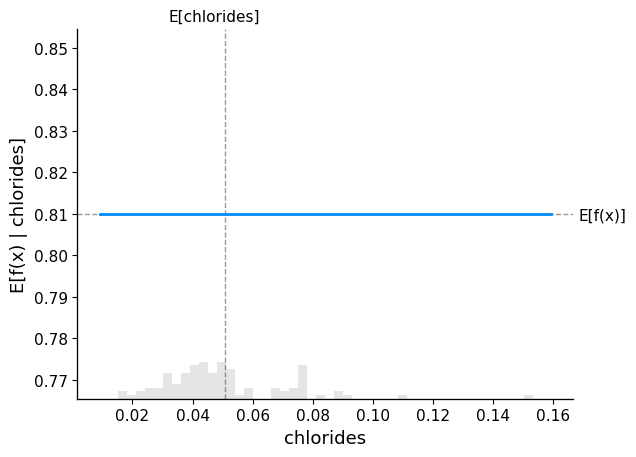

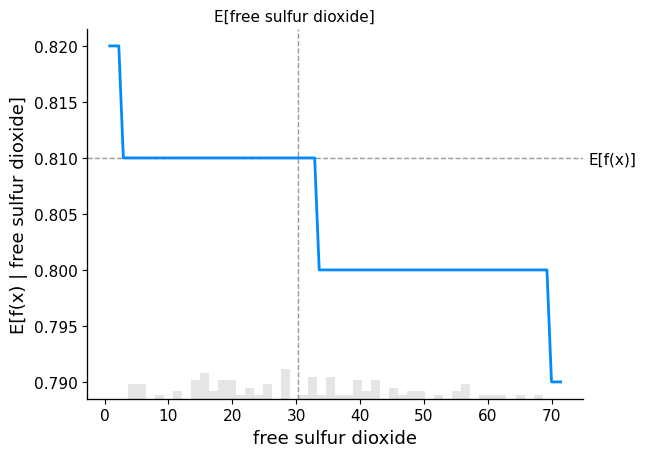

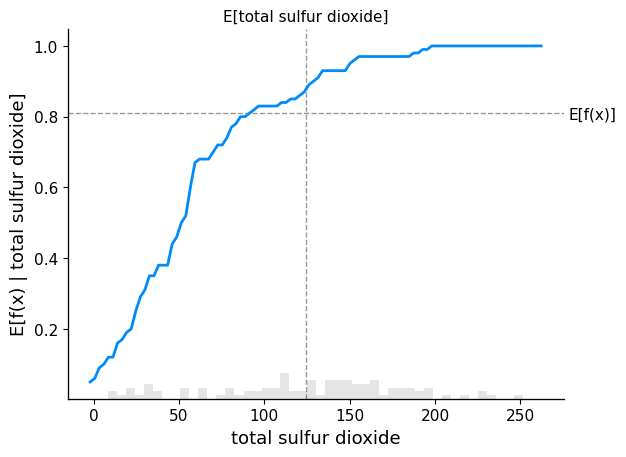

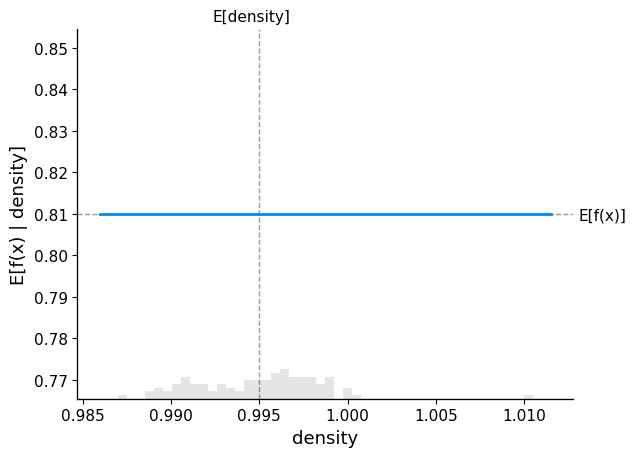

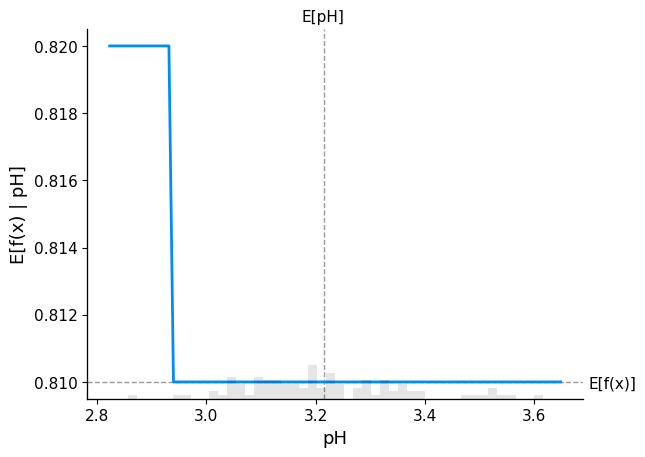

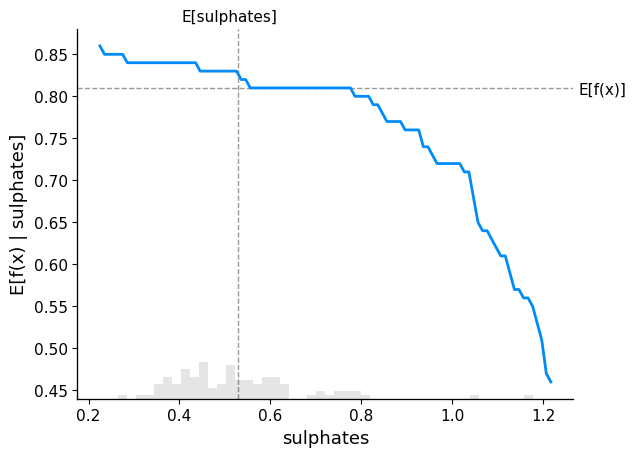

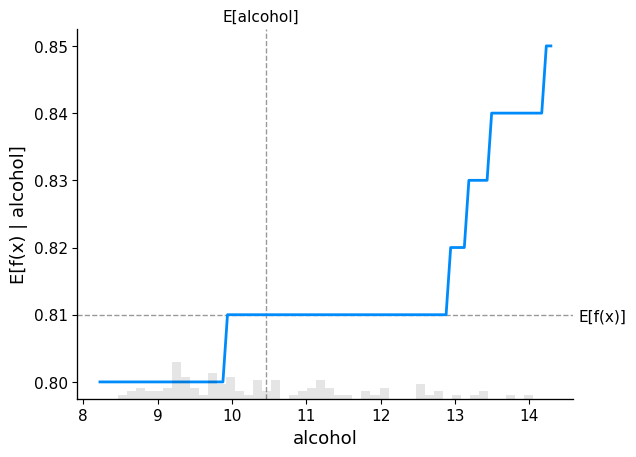

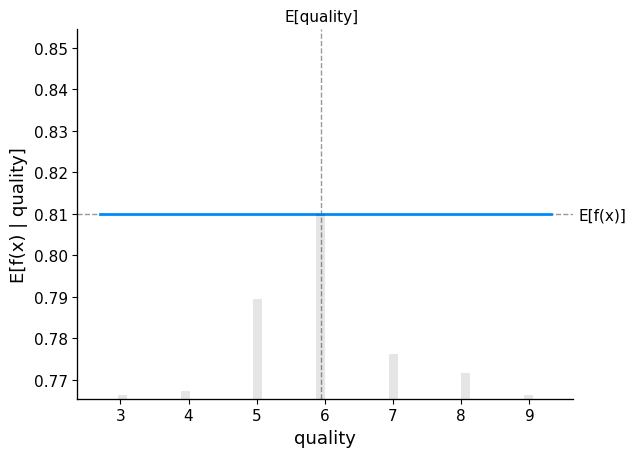

In [30]:
def getShapPartialDependencePlot():
    lg = LogisticRegression(C=50)
    x_train, x_test, y_train, y_test = train_test_split(x_base, y_base, train_size=0.8)
    lblEncoder = LabelEncoder()
    y_train = lblEncoder.fit_transform(y_train)
    lg.fit(x_train, y_train)

    explainer = shap.Explainer(lg, x_train, feature_names=feature)

    X100 = shap.utils.sample(x_train, 100)
    for f in features:
        shap.partial_dependence_plot(
            f,
            lg.predict,
            X100,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
        )


getShapPartialDependencePlot()

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

In [31]:
def shapWaterfall(index):
    lg = LogisticRegression(C=50)
    x_train, x_test, y_train, y_test = train_test_split(
        x_base, y_base, train_size=0.8, random_state=42
    )
    lg.fit(x_train, y_train)
    explainer = shap.Explainer(lg, x_train, feature_names=feature)
    shap_values = explainer(x_test)
    y_predicted = lg.predict(x_test)
    shap.plots.waterfall(shap_values[index])
    # for x, y in enumerate(y_predicted):
    #     if y_test.iloc[x]
    falses = [x for x, y in enumerate(y_predicted) if y_test.iloc[x] != y]
    shap.plots.waterfall(shap_values[falses[0]])

/home/marttave/micromamba/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


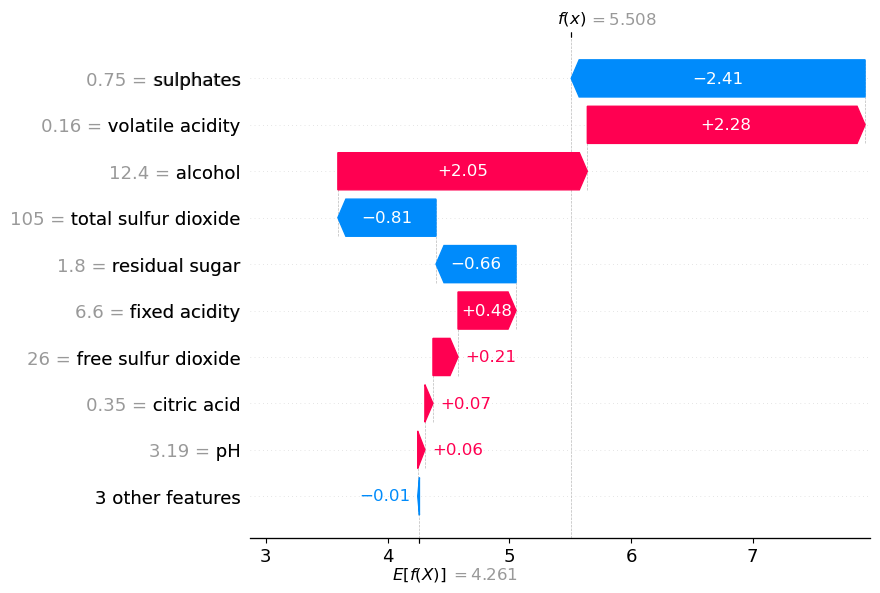

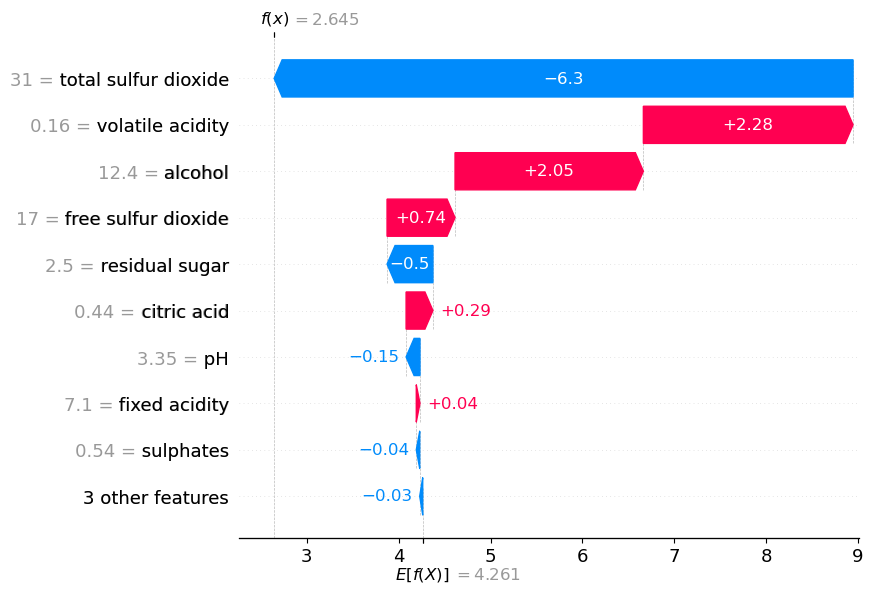

In [32]:
shapWaterfall(5)

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [33]:
# Complete this cell with your code
target = "quality"


def replaceGoodBad(x):
    if x > 6:
        return "good"
    else:
        return "bad"


features = [x for x in base_data.columns.values if x != target]
x_base = base_data[features]
y_base = base_data[target].map(replaceGoodBad)

In [34]:
x_base

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
0,7.0,0.17,0.74,12.80,0.045,24.0,126.0,0.99420,3.26,0.38,12.2,white
1,7.7,0.64,0.21,2.20,0.077,32.0,133.0,0.99560,3.27,0.45,9.9,red
2,6.8,0.39,0.34,7.40,0.020,38.0,133.0,0.99212,3.18,0.44,12.0,white
3,6.3,0.28,0.47,11.20,0.040,61.0,183.0,0.99592,3.12,0.51,9.5,white
4,7.4,0.35,0.20,13.90,0.054,63.0,229.0,0.99888,3.11,0.50,8.9,white
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,7.6,0.32,0.58,16.75,0.050,43.0,163.0,0.99990,3.15,0.54,9.2,white
6493,5.6,0.28,0.27,3.90,0.043,52.0,158.0,0.99202,3.35,0.44,10.7,white
6494,6.4,0.37,0.20,5.60,0.117,61.0,183.0,0.99459,3.24,0.43,9.5,white
6495,6.5,0.26,0.50,8.00,0.051,46.0,197.0,0.99536,3.18,0.47,9.5,white


In [35]:
y_base

0       good
1        bad
2       good
3        bad
4        bad
        ... 
6492     bad
6493    good
6494     bad
6495     bad
6496     bad
Name: quality, Length: 6497, dtype: object

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 

Ideally, there should be almost none. Why could it be a problem otherwise?

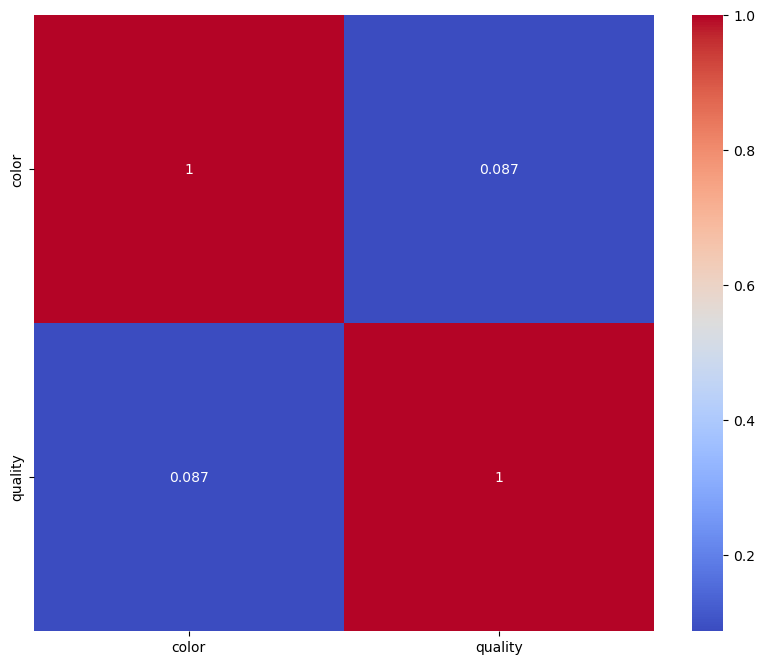

In [36]:
def getQualityCorrMatrix():
    df = pd.DataFrame()
    lblEncoder = LabelEncoder()
    lblEncoder2 = LabelEncoder()
    df["color"] = lblEncoder.fit_transform(x_base["color"])
    df[target] = lblEncoder2.fit_transform(y_base)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
    plt.show()


getQualityCorrMatrix()

If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

In [37]:
num_features = [x for x in features if x != "color"]
good_wines = x_base[y_base == "good"]
bad_wines = x_base[y_base == "bad"]

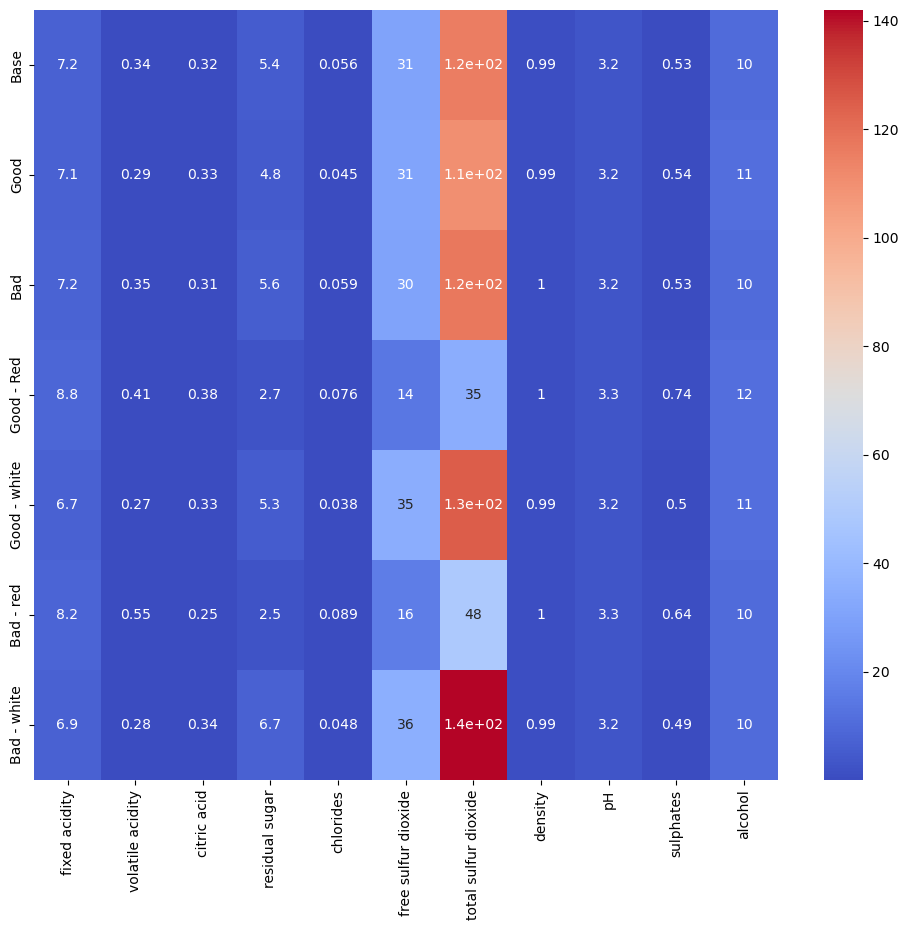

In [38]:
def showFeatureAvgHeatmap():
    base_features_means = base_data[num_features].mean()
    good_wines_means = good_wines[num_features].mean()
    bad_wines_means = bad_wines[num_features].mean()
    good_red_wines = good_wines[good_wines["color"] == "red"][num_features].mean()
    good_white_wines = good_wines[good_wines["color"] == "white"][num_features].mean()
    bad_red_wines = bad_wines[bad_wines["color"] == "red"][num_features].mean()
    bad_white_wines = bad_wines[bad_wines["color"] == "white"][num_features].mean()
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        [
            base_features_means,
            good_wines_means,
            bad_wines_means,
            good_red_wines,
            good_white_wines,
            bad_red_wines,
            bad_white_wines,
        ],
        annot=True,
        cmap="coolwarm",
        xticklabels=num_features,
        yticklabels=[
            "Base",
            "Good",
            "Bad",
            "Good - Red",
            "Good - white",
            "Bad - red",
            "Bad - white",
        ],
    )
    plt.show()


showFeatureAvgHeatmap()

As we can see, there is no visible difference between good and bad wine. This won't be this easy

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

From now on, we will focus only on the white wines for our analysis

In [39]:
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
}

model = XGBClassifier()
# onehotEncoder = OneHotEncoder(sparse_output=False)
# x_encoded = x_base[num_features].copy(deep=True)
# encoded_data = onehotEncoder.fit_transform(x_base[["color"]])
# encoded_df = pd.DataFrame(
#     encoded_data, columns=onehotEncoder.get_feature_names_out(["color"])
# )
# for c in encoded_df.columns.values:
#     x_encoded[c] = encoded_df[c]
lblEncoder = LabelEncoder()
y_encoded = lblEncoder.fit_transform(y_base[x_base["color"] == "white"])
x_train, x_test, y_train, y_test = train_test_split(
    x_base[x_base["color"] == "white"][num_features], y_encoded, train_size=0.8
)

cv = GridSearchCV(model, param_grid, scoring="f1", n_jobs=-1)

cv.fit(x_train, y_train)

print(f"Best params were : {cv.best_params_}")
print(f"Best score is : {cv.best_score_}")
bestModel = cv.best_estimator_

Best params were : {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Best score is : 0.6095181175313442


- Analyze the results (test and train), validate whether there is overfitting.

In [40]:
y_pred = bestModel.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91       754
           1       0.79      0.50      0.62       226

    accuracy                           0.86       980
   macro avg       0.83      0.73      0.76       980
weighted avg       0.85      0.86      0.84       980



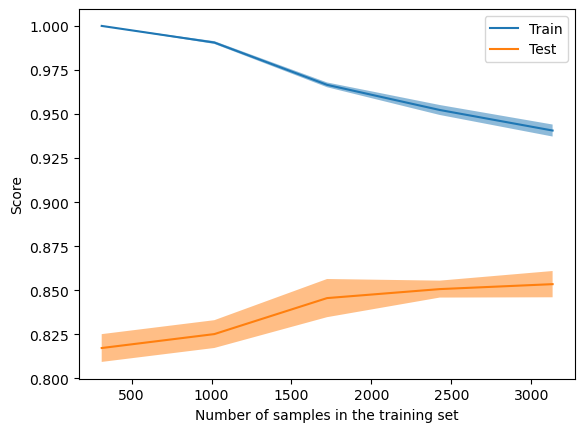

In [41]:
LearningCurveDisplay.from_estimator(bestModel, x_train, y_train, n_jobs=-1)

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

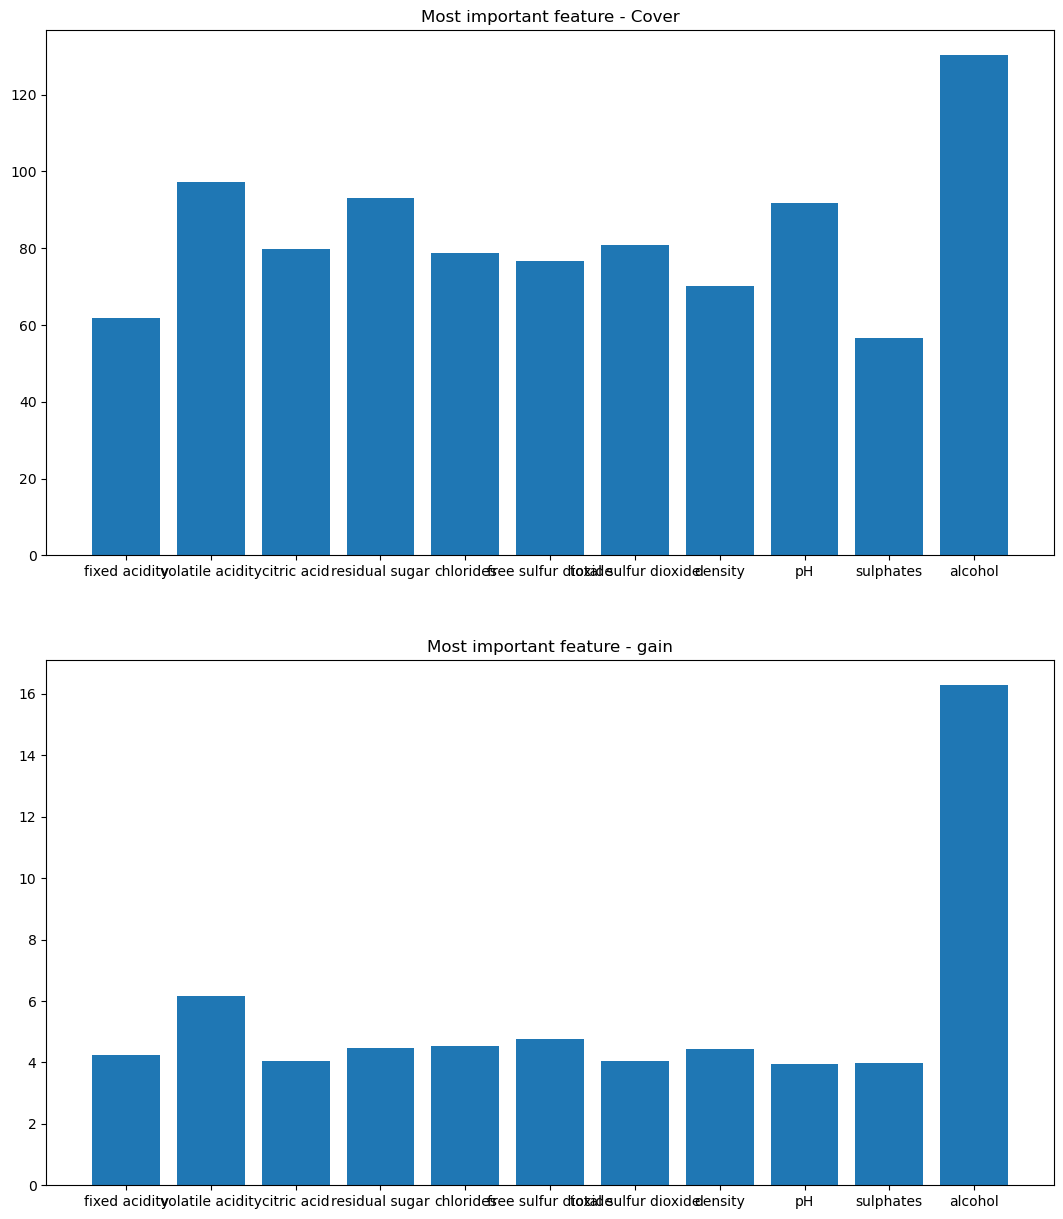

In [42]:
# Complete this cell with your code
import xgboost as xgb

# Set feature names

cover = bestModel.get_booster().get_score(importance_type="cover")
gain = bestModel.get_booster().get_score(importance_type="gain")

# Plot feature importance
plt.figure(figsize=(13, 15))
plt.subplot(2, 1, 1)
plt.bar(cover.keys(), cover.values())
plt.title("Most important feature - Cover")
plt.subplot(2, 1, 2)
plt.bar(gain.keys(), gain.values())
plt.title("Most important feature - gain")
plt.show()

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

In [43]:
from shap import TreeExplainer


explainer = TreeExplainer(bestModel)

shap_values = explainer(x_train)

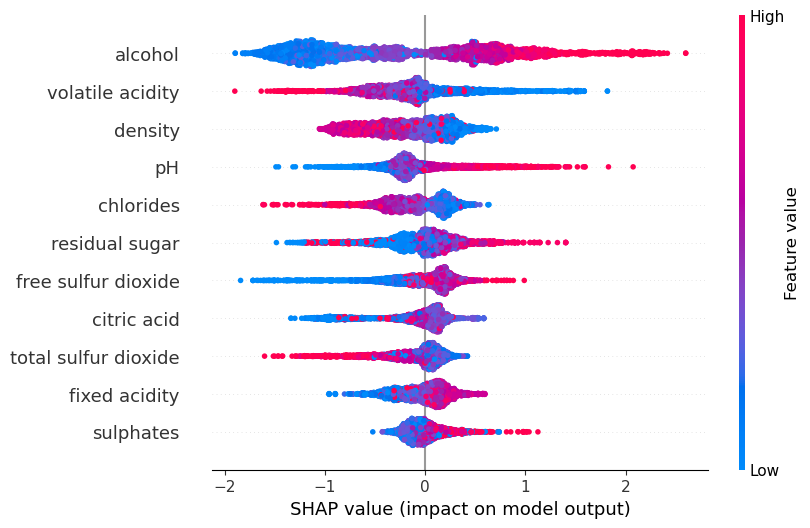

In [44]:
shap.plots.beeswarm(shap_values, max_display=20)

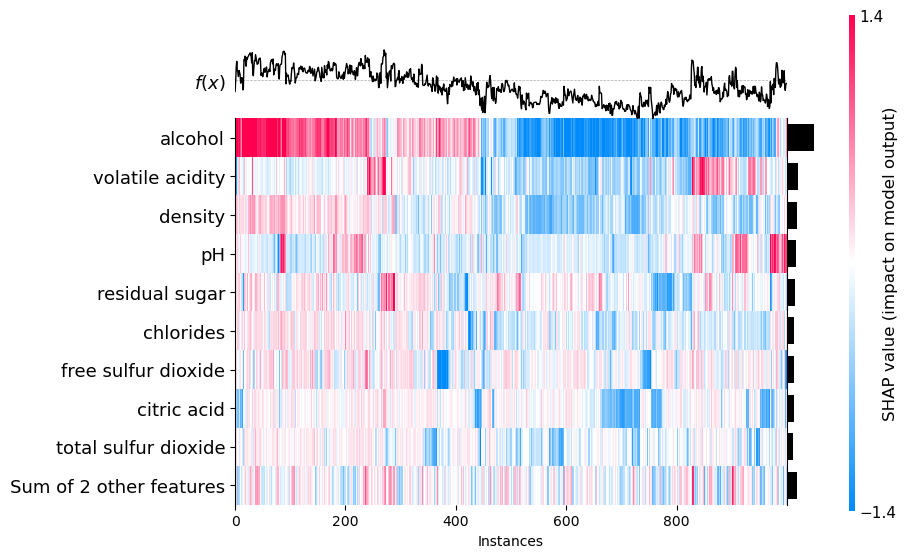

<Axes: xlabel='Instances'>

In [45]:
shap.plots.heatmap(shap_values[:1000])

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

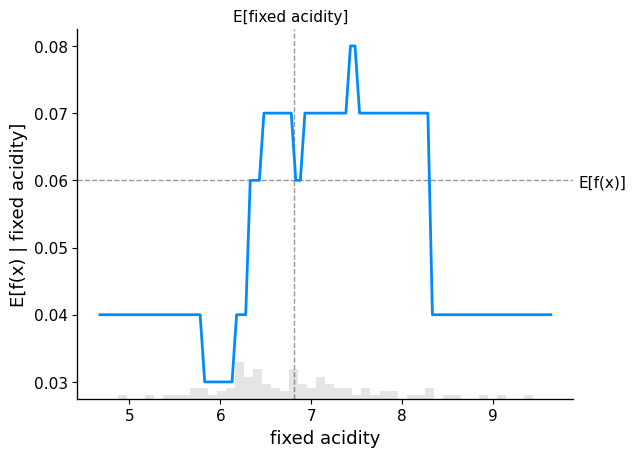

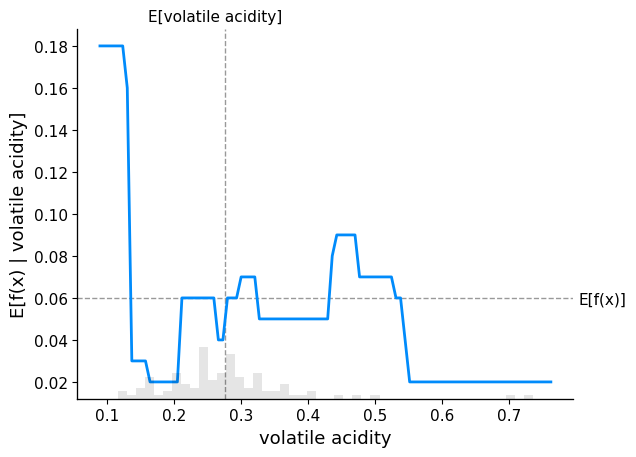

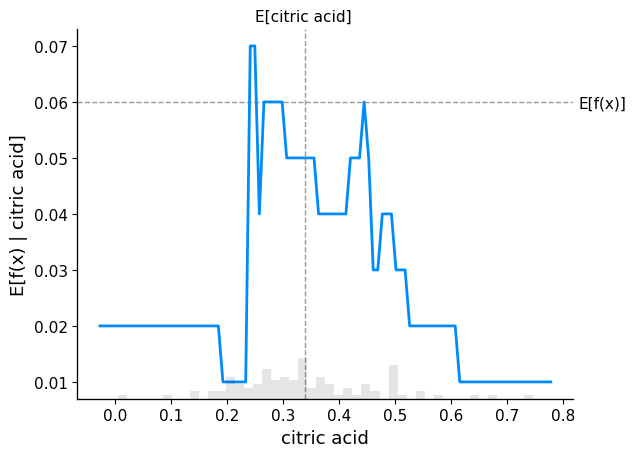

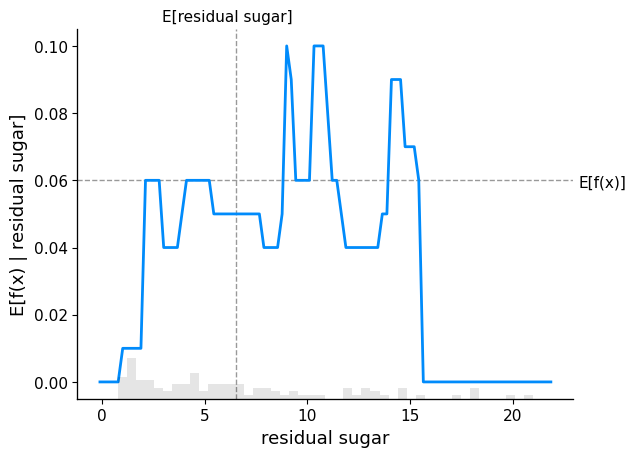

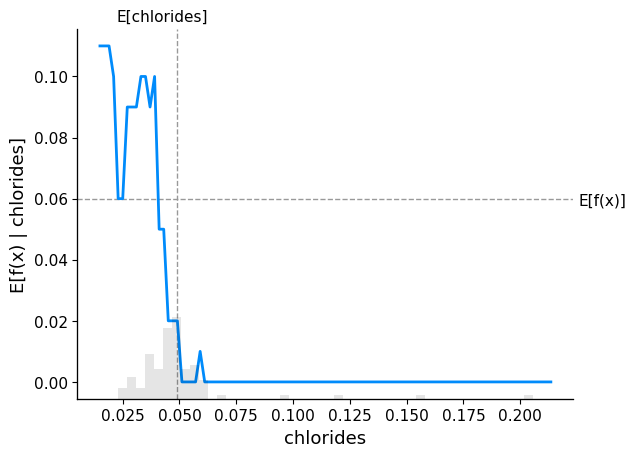

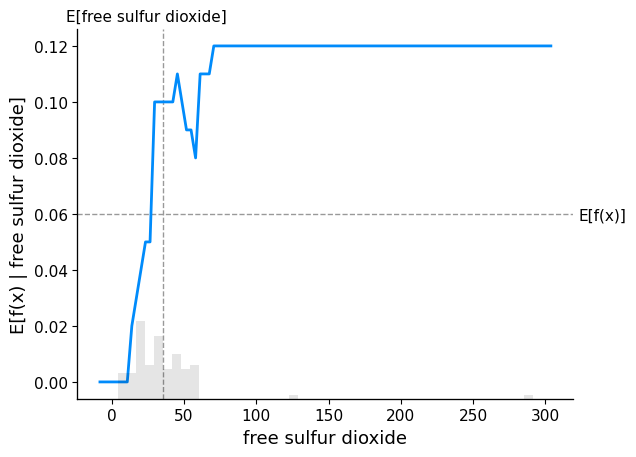

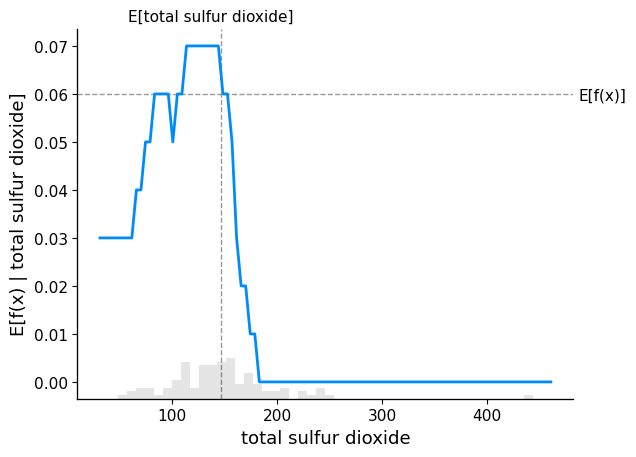

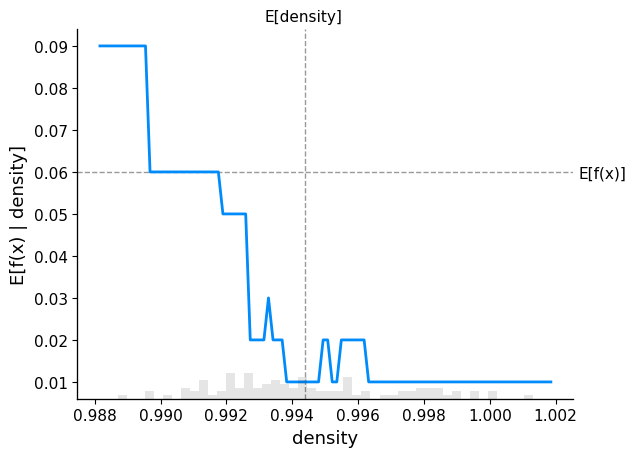

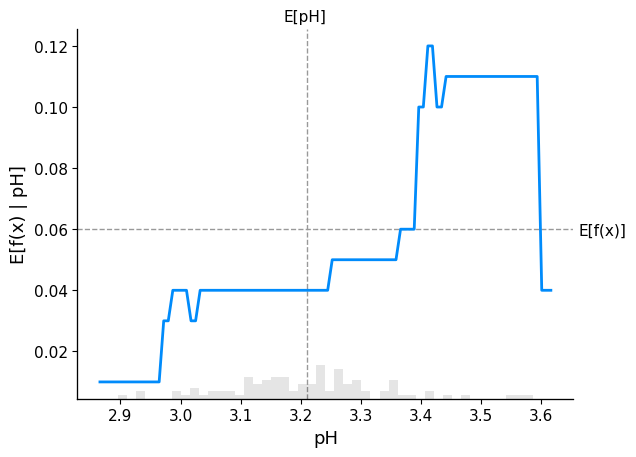

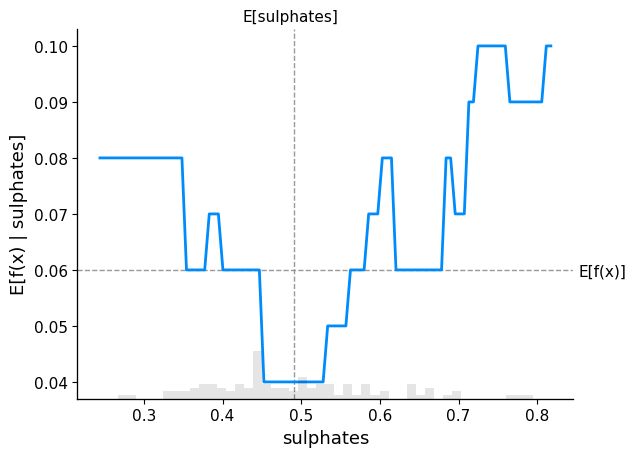

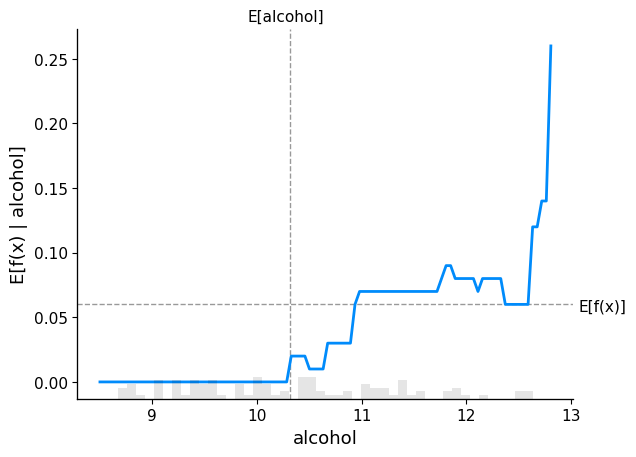

In [46]:
def getShapPartialDependencePlot():
    X100 = shap.utils.sample(x_train, 100)
    for f in num_features:
        shap.partial_dependence_plot(
            f,
            bestModel.predict,
            X100,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
        )


getShapPartialDependencePlot()

We can see that for certain features, it's quite messy. And for other, it may indicate a sweeetspot.

For example, for the chlorides. Here it is clear that the value have a range considered as good. And everything outside of this is bad. It is even clearer with the `total sulfur dioxide`, everything greater than ~150 is considered bad.

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

After some searching, some findings that I got are quite well aligned with the resources I found. For example, the chlorides. Apprently, you want to keep the chlorides as low as possible to get a good white wine.

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

In [59]:
from shap import TreeExplainer


explainer = TreeExplainer(bestModel)
encoded = lblEncoder.transform(["bad"])[0]
mask = y_train == encoded

shap_values = explainer(x_train[mask])

In [60]:
x_train[mask]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
303,6.8,0.22,0.30,10.6,0.070,67.0,194.0,0.99654,2.89,0.42,9.0
4671,7.3,0.17,0.23,6.3,0.051,35.0,240.0,0.99630,3.36,0.54,10.0
2836,6.2,0.24,0.25,12.5,0.055,47.0,134.0,0.99758,3.30,0.51,9.0
3862,8.9,0.33,0.32,1.5,0.047,11.0,200.0,0.99540,3.19,0.46,9.4
500,6.6,0.32,0.27,10.9,0.041,37.0,146.0,0.99630,3.24,0.47,10.0
...,...,...,...,...,...,...,...,...,...,...,...
1112,8.1,0.26,0.37,1.9,0.072,48.0,159.0,0.99490,3.37,0.70,10.9
5170,6.3,0.31,0.30,10.0,0.046,49.0,212.0,0.99620,3.74,0.55,11.9
2453,7.6,0.29,0.29,4.4,0.051,26.0,146.0,0.99390,3.16,0.39,10.2
3001,6.6,0.38,0.36,9.2,0.061,42.0,214.0,0.99760,3.31,0.56,9.4


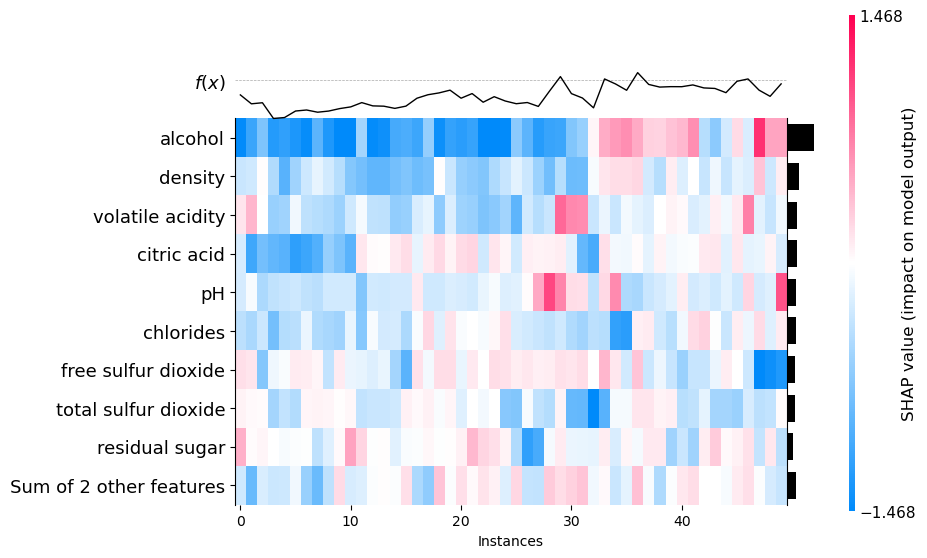

<Axes: xlabel='Instances'>

In [70]:
shap.plots.heatmap(shap_values[:50])

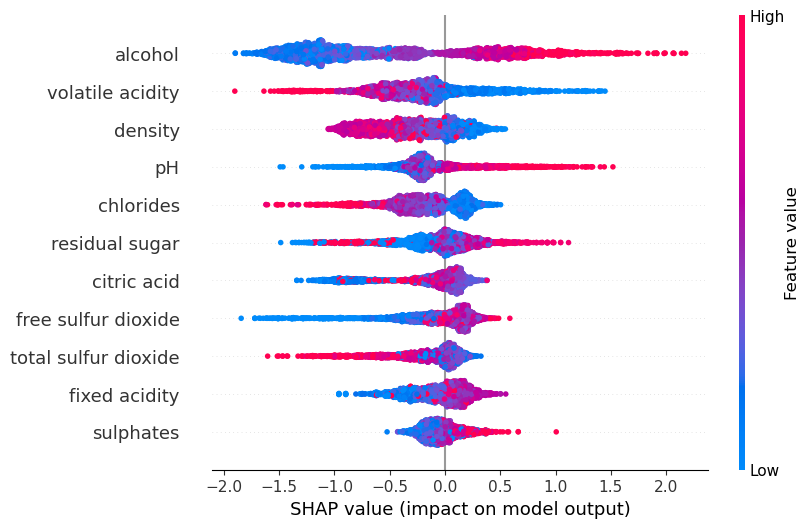

In [73]:
shap.plots.beeswarm(shap_values, max_display=12)

As we can see, our model saw some good wines with great content in alcohol. So our model has a great weight on the alcohol feature. And this causes some missclassification. But on feature that seems to be quite correct is the chlorides. The lowest the better

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.